In [1]:
# Caso seja necessário descomente e execute o comando abaixo. 
# Feito isso, será necessário reiniciar o notebook e executá-lo novamente
#pip install --upgrade category_encoders

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from category_encoders.one_hot import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from category_encoders.ordinal import OrdinalEncoder

## Carregando os datasets

In [3]:
df1 = pd.read_csv('ACCOUNTS.csv')
df2 = pd.read_csv('DEMOGRAPHICS.csv')
df3 = pd.read_csv('LOANS.csv')

## Visão Geral

Compreender cada informação coletada é essencial para um possível modelo que será gerado. Nesse sentido, gera-se uma análise inicial de cada variável (ou coluna) foi coletada e justifica-se o porque dessa variável não será considerada no modelo ou até mesmo, qual tratamento de dados será utilizado nela.

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2477 non-null   int64  
 1   CHECKING_BALANCE        2467 non-null   object 
 2   CREDIT_HISTORY          2462 non-null   object 
 3   EXISTING_SAVINGS        2467 non-null   object 
 4   EXISTING_CREDITS_COUNT  2463 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 96.9+ KB


A função <strong>info()</strong> já mostra um resumo geral do comportamento dos dados, apesar de superficial é possível observar que os dados estão desbalanceados, ou seja, será necessário realizar uma análise exploratória individual de cada variável e posteriormente realizar um tratamento e limpeza de informações que não terão impacto no modelo de classificação que se almeja construir.

# Fase 1: Análise individual de cada variável, tratamento de dados, junção das bases de dados, análise de outliers.

## - Análise Inicial de Dados 1 - 'accounts.csv'


In [5]:
df1

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
0,291655,-566.53,ALL_CREDITS_PAID_BACK,36.42,1.0
1,657079,-1673.16,CREDITS_PAID_TO_DATE,22.9,1.0
2,256050,NO_CHECKING,CREDITS_PAID_TO_DATE,450.35,2.0
3,1039151,-1471.03,PRIOR_PAYMENTS_DELAYED,805.71,2.0
4,1002660,NO_CHECKING,CREDITS_PAID_TO_DATE,295.03,1.0
...,...,...,...,...,...
2472,636739,163.82,CREDITS_PAID_TO_DATE,472.11,1.0
2473,919733,14324.23,PRIOR_PAYMENTS_DELAYED,18652.44,1.0
2474,115839,130.13,PRIOR_PAYMENTS_DELAYED,726.78,2.0
2475,1128684,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0


In [6]:
df1.corr() 

,ID,EXISTING_CREDITS_COUNT
ID,1.000000,-0.003681
EXISTING_CREDITS_COUNT,-0.003681,1.000000


In [7]:
df1[df1['CHECKING_BALANCE']=='NO_CHECKING']

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
2,256050,NO_CHECKING,CREDITS_PAID_TO_DATE,450.35,2.0
4,1002660,NO_CHECKING,CREDITS_PAID_TO_DATE,295.03,1.0
6,1096578,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,421.96,1.0
10,1136574,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,383.57,1.0
12,1268579,NO_CHECKING,OUTSTANDING_CREDIT,572.37,2.0
...,...,...,...,...,...
2468,827553,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,615.54,2.0
2469,145488,NO_CHECKING,OUTSTANDING_CREDIT,33154.86,2.0
2470,178072,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,726.26,2.0
2475,1128684,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0


In [8]:
df1[df1['EXISTING_SAVINGS']=='UNKNOWN']

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
23,1049084,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
26,1177670,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
31,584707,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
32,100984,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,3.0
36,29700,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
...,...,...,...,...,...
2380,514189,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,2.0
2429,816269,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
2438,1152672,97.91,OUTSTANDING_CREDIT,UNKNOWN,2.0
2475,1128684,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0


### 1) Com relação aos saldo da conta de cada cliente, qual a relação entre verificados e não verificados? 

In [9]:
# Dividi-se o dataset em 2, onde a variável check é compreendida pelas informações numéricas.
no_check = len(df1[df1[u'CHECKING_BALANCE'] == 'NO_CHECKING'])
check = len(df1[df1[u'CHECKING_BALANCE'] != 'NO_CHECKING'])

new_df = {'NO_CHECKING': [no_check], 'CHECKING': [check]}

checking_balance = pd.DataFrame(data=new_df)

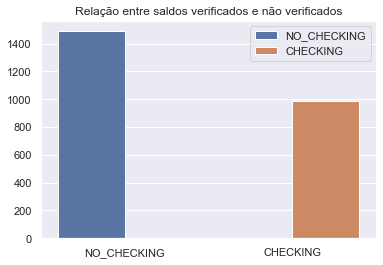

In [10]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(checking_balance) ,y=[checking_balance['CHECKING'].iloc[0],checking_balance['NO_CHECKING'].iloc[0]],hue=list(checking_balance))
plt.title("Relação entre saldos verificados e não verificados")
plt.show(fig)

### 2) Quais características estão presentes na coluna 'Histórico de Crédito'?

In [11]:
df1['CREDIT_HISTORY'].unique()

array(['ALL_CREDITS_PAID_BACK', 'CREDITS_PAID_TO_DATE',
       'PRIOR_PAYMENTS_DELAYED', 'OUTSTANDING_CREDIT', 'NO_CREDITS', nan],
      dtype=object)

### 3) Qual a relação entre economias conhecidas e desconhecidas dos clientes com o banco?

In [12]:
# Dividi-se o dataset em 2, onde a variável check é compreendida pelas informações numéricas.
exis = len(df1[df1[u'EXISTING_SAVINGS'] != 'UNKNOWN'])
no_exis = len(df1[df1[u'EXISTING_SAVINGS'] == 'UNKNOWN'])

new_df2 = {'EXISTING_SAVINGS': [exis], 'NO_EXISTING_SAVINGS': [no_exis]}

check_savings = pd.DataFrame(data=new_df2)

In [13]:
check_savings

,EXISTING_SAVINGS,NO_EXISTING_SAVINGS
0,2301,176


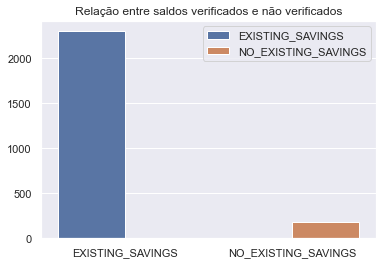

In [14]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_savings) ,y=[check_savings['EXISTING_SAVINGS'].iloc[0],
                                            check_savings['NO_EXISTING_SAVINGS'].iloc[0]],
                                            hue=list(check_savings))
plt.title("Relação entre saldos verificados e não verificados")
plt.show(fig)

In [15]:
df1[df1['EXISTING_CREDITS_COUNT'].isnull()]

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
34,1205053,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,600.14,NaN
38,245917,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,1788.77,NaN
193,205835,-665.67,ALL_CREDITS_PAID_BACK,441.07,NaN
295,501397,-99.73,ALL_CREDITS_PAID_BACK,24.02,NaN
461,676771,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,NaN
770,463004,590.68,CREDITS_PAID_TO_DATE,15.83,NaN
1127,839628,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,813.85,NaN
1232,1135727,0.5,ALL_CREDITS_PAID_BACK,78.54,NaN
1428,794570,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,NaN
1498,773770,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,151.43,NaN


## -  Análise Inicial de Dados 2 - 'demographics.csv'

In [16]:
df2

,ID,SEX,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,EMPLOYMENT_DURATION,PROPERTY,HOUSING,CURRENT_RESIDENCE_DURATION
0,24252,M,47.0,3.0,1.0,0.0,1.0,14.0,SAVINGS_INSURANCE,OWN,3.0
1,1002018,M,19.0,3.0,1.0,0.0,1.0,0.0,SAVINGS_INSURANCE,RENT,2.0
2,1240455,F,50.0,2.0,1.0,1.0,1.0,7.0,UNKNOWN,OWN,3.0
3,107799,M,35.0,3.0,1.0,0.0,1.0,0.0,REAL_ESTATE,OWN,2.0
4,184883,M,40.0,1.0,1.0,0.0,1.0,9.0,CAR_OTHER,OWN,4.0
...,...,...,...,...,...,...,...,...,...,...,...
3931,636739,F,41.0,0.0,1.0,0.0,1.0,7.0,CAR_OTHER,OWN,3.0
3932,919733,M,46.0,3.0,1.0,1.0,1.0,11.0,SAVINGS_INSURANCE,OWN,3.0
3933,115839,M,28.0,3.0,1.0,1.0,1.0,7.0,CAR_OTHER,RENT,1.0
3934,1128684,M,46.0,0.0,1.0,0.0,1.0,7.0,CAR_OTHER,RENT,3.0


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936 entries, 0 to 3935
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          3936 non-null   int64  
 1   SEX                         3920 non-null   object 
 2   AGE                         3918 non-null   float64
 3   JOB_TYPE                    3910 non-null   float64
 4   DEPENDENTS                  3915 non-null   float64
 5   TELEPHONE                   3915 non-null   float64
 6   FOREIGN_WORKER              3909 non-null   float64
 7   EMPLOYMENT_DURATION         3923 non-null   float64
 8   PROPERTY                    3918 non-null   object 
 9   HOUSING                     3912 non-null   object 
 10  CURRENT_RESIDENCE_DURATION  3917 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 338.4+ KB


### Qual o sexo dos clientes?

In [18]:
df2['SEX'].value_counts()

M    2419
F    1501
Name: SEX, dtype: int64

In [19]:
df2['SEX'].fillna("NR", inplace = True)

In [20]:
# Dividi-se o dataset em 2, onde a variável check é compreendida pelas informações numéricas.
sex_M = len(df2[df2[u'SEX'] == 'M'])
sex_F = len(df2[df2[u'SEX'] == 'F'])
sex_NR = len(df2[df2[u'SEX'] == 'NR']) # não respondido (NaN)

new_df2 = {'M': [sex_M], 'F': [sex_F]}

check_sex = pd.DataFrame(data=new_df2)

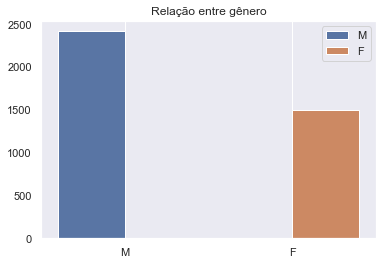

In [21]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_sex),
                  y=[check_sex['M'].iloc[0],
                     check_sex['F'].iloc[0]],
                     hue=list(check_sex))
plt.grid(None)
plt.title("Relação entre gênero")
plt.rcParams["figure.figsize"] = (4,6)
plt.show(fig)

Nesse caso, baseado nos dados optamos por apenas apresentar a relação entre o sexo Masculino e Feminino para dados bancários. Vale ressaltar que o índice percentual de pessoas que ou não responderam, ou que por alguma instabilidade do sistema não foi salva é de 0.4% no total (16 registros sem resposta). Mas isso não é tudo, é importante entender também qual amostra está a nossa disposição, no caso, essa amostra tem exatos 3936 dados.

### Qual a distribuição a cerca da idade dos nossos clientes?

Para auxiliar nessa tarefa, criamos alguns filtros para compreender melhor a qual faixa etária os clientes da BanTotal pertencem. 

In [22]:
#df2['AGE'].value_counts()

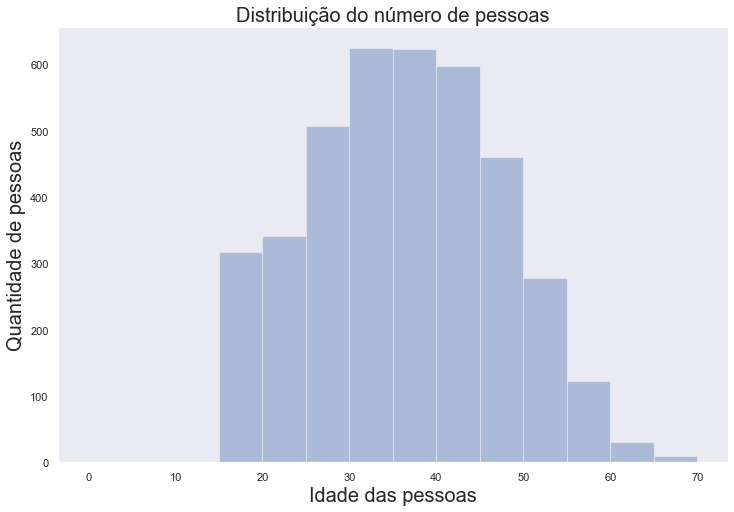

In [23]:
ax = sns.distplot(df2.AGE, kde = False, 
                  bins = [i*5 for(i) in range (15)])
ax.set_xlabel("Idade das pessoas", 
              fontsize = 20, 
              position=(0.5,0))

ax.set_ylabel("Quantidade de pessoas", 
              fontsize = 20, 
              position=(0.5,0.5))

ax.grid(None)

ax.set_title('Distribuição do número de pessoas', 
             fontsize = 20)

ax.figure.set_size_inches(12,8)

### Qual a distribuição que indica quantos dependentes nossos clientes têm?



In [24]:
df2['DEPENDENTS'].value_counts()

1.0    3284
2.0     631
Name: DEPENDENTS, dtype: int64

In [25]:
dep1 = len(df2[df2[u'DEPENDENTS'] == 1.0])
dep2 = len(df2[df2[u'DEPENDENTS'] == 2.0])

new_df3 = {'1.0': [dep1], '2.0': [dep2]}

check_dependence = pd.DataFrame(data=new_df3)
check_dependence

,1.0,2.0
0,3284,631


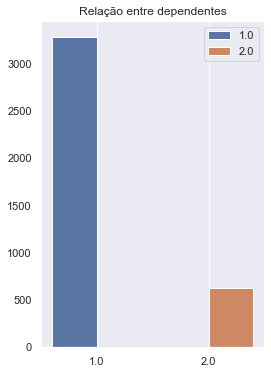

In [26]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_dependence),
                  y=[check_dependence['1.0'].iloc[0],
                     check_dependence['2.0'].iloc[0]],
                     hue=list(check_dependence))
plt.grid(None)
plt.title("Relação entre dependentes")
plt.rcParams["figure.figsize"] = (4,6)
plt.show(fig)

### O cliente tem telefone registrado no sistema?

0 - não

1 - sim


In [27]:
df2['TELEPHONE'].value_counts()

0.0    2302
1.0    1613
Name: TELEPHONE, dtype: int64

In [28]:
phone1 = len(df2[df2[u'TELEPHONE'] == 0.0])
phone2 = len(df2[df2[u'TELEPHONE'] == 1.0])

new_df4 = {'Sim': [phone1], 'Não': [phone2]}

check_phone = pd.DataFrame(data=new_df4)

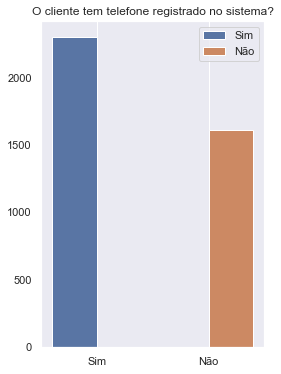

In [29]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_phone),
                  y=[check_phone['Sim'].iloc[0],
                     check_phone['Não'].iloc[0]],
                     hue=list(check_phone))
plt.grid(None)
plt.title("O cliente tem telefone registrado no sistema?")
plt.rcParams["figure.figsize"] = (6,8)
plt.show(fig)

### O cliente é um trabalhador estrangeiro?



In [30]:
df2['FOREIGN_WORKER'].value_counts()

1.0    3814
0.0      95
Name: FOREIGN_WORKER, dtype: int64

In [31]:
w1 = len(df2[df2[u'FOREIGN_WORKER'] == 0.0])
w2 = len(df2[df2[u'FOREIGN_WORKER'] == 1.0])

new_df4 = {'Sim': [w2], 'Não': [w1]}

check_worker = pd.DataFrame(data=new_df4)

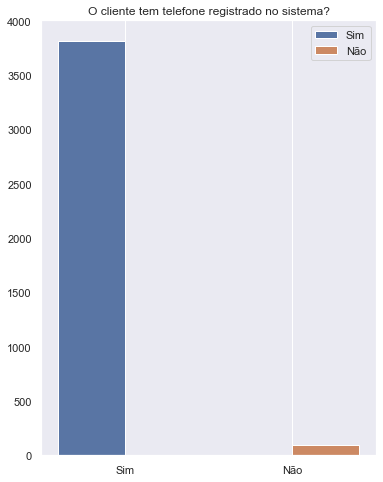

In [32]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_worker),
                  y=[check_worker['Sim'].iloc[0],
                     check_worker['Não'].iloc[0]],
                     hue=list(check_worker))
plt.grid(None)
plt.title("O cliente tem telefone registrado no sistema?")
plt.rcParams["figure.figsize"] = (6,8)
plt.show(fig)

### Duração do Trabalho

In [33]:
df2['EMPLOYMENT_DURATION'].value_counts()

0.0     929
5.0     390
7.0     372
6.0     351
1.0     314
3.0     290
2.0     275
4.0     275
8.0     192
9.0     180
10.0    143
11.0     90
12.0     73
13.0     24
14.0     11
15.0     10
16.0      2
18.0      1
17.0      1
Name: EMPLOYMENT_DURATION, dtype: int64

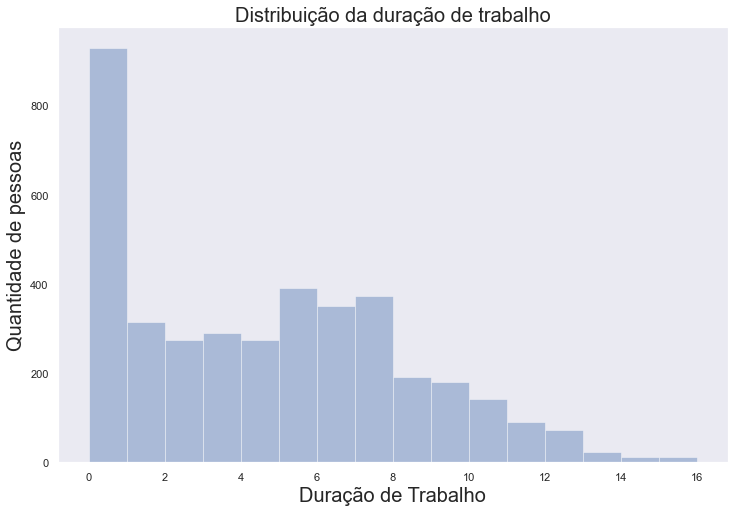

In [34]:
ax = sns.distplot(df2.EMPLOYMENT_DURATION, kde = False, 
                  bins = [i for(i) in range (17)])

ax.set_xlabel("Duração de Trabalho", 
              fontsize = 20, 
              position=(0.5,0))

ax.set_ylabel("Quantidade de pessoas", 
              fontsize = 20, 
              position=(0.5,0.5))

ax.grid(None)

ax.set_title('Distribuição da duração de trabalho', 
             fontsize = 20)

ax.figure.set_size_inches(12,8)

### Propriedade

In [35]:
df2['PROPERTY'].unique()

array(['SAVINGS_INSURANCE', 'UNKNOWN', 'REAL_ESTATE', 'CAR_OTHER', nan],
      dtype=object)

### Habitação

In [36]:
df2['HOUSING'].unique()

array(['OWN', 'RENT', 'FREE', nan], dtype=object)

### Duração de Residência Atual

In [37]:
df2['CURRENT_RESIDENCE_DURATION'].value_counts()

3.0    1304
2.0     986
4.0     854
1.0     486
5.0     284
6.0       3
Name: CURRENT_RESIDENCE_DURATION, dtype: int64

In [38]:
crd1 = len(df2[df2[u'FOREIGN_WORKER'] == 1.0])
crd2 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 2.0])
crd3 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 3.0])
crd4 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 4.0])
crd5 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 5.0])
crd6 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 6.0])

new_df5 = {'1': [crd1], '2': [crd2], '3': [crd3], '4': [crd4], '5': [crd5], '6': [crd6]}

check_crd = pd.DataFrame(data=new_df5)

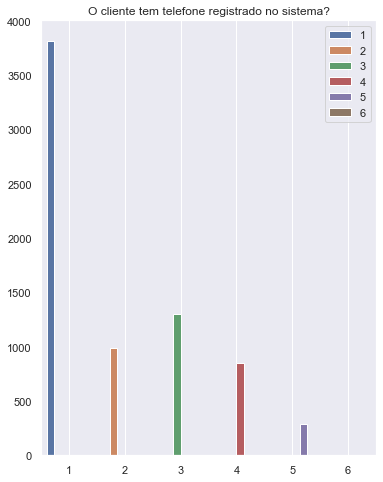

In [39]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_crd),
                  y=[check_crd['1'].iloc[0],
                     check_crd['2'].iloc[0],
                     check_crd['3'].iloc[0],
                     check_crd['4'].iloc[0],
                     check_crd['5'].iloc[0],
                     check_crd['6'].iloc[0]],
                     hue=list(check_crd))
plt.grid(None)
plt.title("O cliente tem telefone registrado no sistema?")
plt.rcParams["figure.figsize"] = (12,12)
plt.show(fig)

#### Questão x: De acordo com os insights obtidos nas questões anteriores, quais serão as decisões de tratamento a serem adotadas nos dados?



## - Análise Inicial de Dados 3 - 'LOANS.csv'

In [40]:
df3

,ID,PAYMENT_TERM,INSTALLMENT_PLANS,INSTALLMENT_PERCENT,LOAN_PURPOSE,LOAN_AMOUNT,OTHERS_ON_LOAN,ALLOW
0,610339,713.0,STORES,3.0,CAR_USED,3103.0,NONE,1
1,109167,341.0,STORES,1.0,CAR_NEW,716.0,NONE,1
2,823322,868.0,NONE,4.0,APPLIANCES,4333.0,NONE,1
3,322224,310.0,STORES,2.0,FURNITURE,250.0,NONE,1
4,912693,620.0,NONE,2.0,CAR_USED,2454.0,NONE,0
...,...,...,...,...,...,...,...,...
3994,636739,450.0,BANK,3.0,CAR_NEW,3007.0,CO-APPLICANT,0
3995,919733,510.0,NONE,4.0,VACATION,4191.0,GUARANTOR,1
3996,115839,124.0,STORES,1.0,FURNITURE,250.0,NONE,1
3997,1128684,961.0,BANK,3.0,BUSINESS,5172.0,NONE,1


Esse dataset é composto por informações amplamento correlacionadas a uma possível concessão de crédito para os clientes da BanTotal. Cada cliente é identificado por uma chave ID e também há outras variávéis como: Termo de Pagamento, Percentual de Parcelamento, Objetivo do Empréstimo, Montante do Empréstimo, Outros Empréstimos, Permitir. Mas fique atento, apenas a leitura superficial das colunas do conjunto de dados não é suficiente para tirar conclusões ou sair aplicando funções de limpeza de dados, é importante estudar individualmente cada variável e formular hipóteses de como remodelar essa variável para constribuir para o modelo que será construído. Um exemplo disso são as variáveis categóricas (não numéricas) contidas no conjunto de dados acima.

### Termo de Pagamento

In [41]:
df3.PAYMENT_TERM

0        713.0
1        341.0
2        868.0
3        310.0
4        620.0
         ...  
3994     450.0
3995     510.0
3996     124.0
3997     961.0
3998    1020.0
Name: PAYMENT_TERM, Length: 3999, dtype: float64

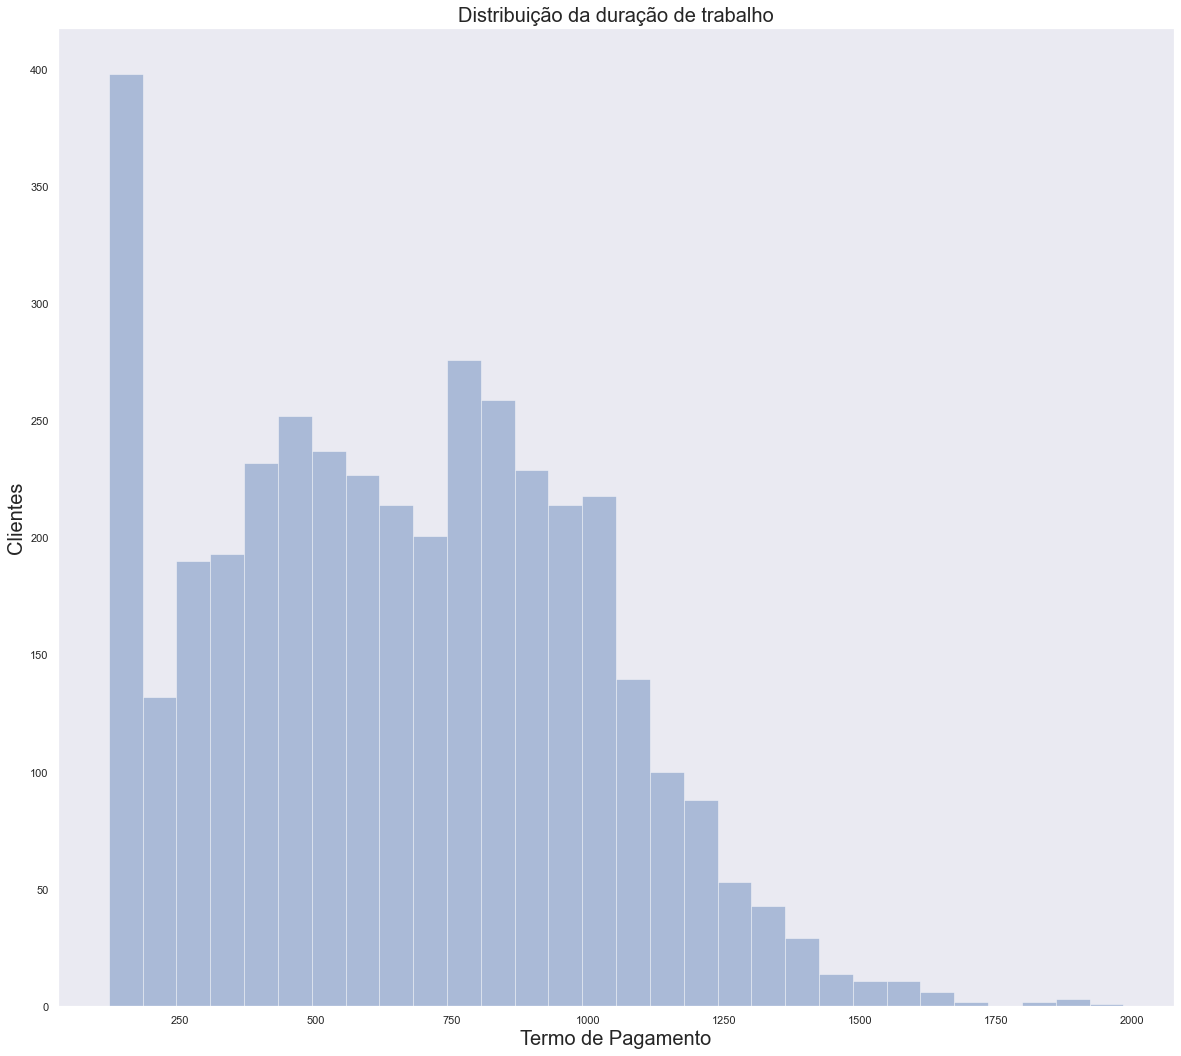

In [42]:
ax = sns.distplot(df3.PAYMENT_TERM, kde = False)

ax.set_xlabel("Termo de Pagamento", 
              fontsize = 20, 
              position=(0.5,0))

ax.set_ylabel("Clientes", 
              fontsize = 20, 
              position=(0.5,0.5))

ax.grid(None)

ax.set_title('Distribuição da duração de trabalho', 
             fontsize = 20)

ax.figure.set_size_inches(20,18)

### Planos de Parcelamento

In [43]:
df3['INSTALLMENT_PLANS'].unique()

array(['STORES', 'NONE', 'BANK', nan], dtype=object)

### Percentual de Parcelamento

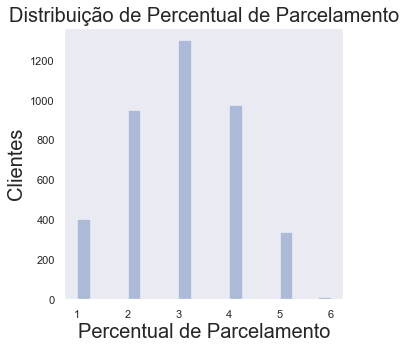

In [44]:
ax = sns.distplot(df3.INSTALLMENT_PERCENT, kde = False)

ax.set_xlabel("Percentual de Parcelamento", 
              fontsize = 20, 
              position=(0.5,0))

ax.set_ylabel("Clientes", 
              fontsize = 20, 
              position=(0.5,0.5))

ax.grid(None)

ax.set_title('Distribuição de Percentual de Parcelamento', 
             fontsize = 20)

ax.figure.set_size_inches(5,5)

### Objetivo do Empréstimo

In [45]:
aux = df3['LOAN_PURPOSE'].value_counts()
aux

CAR_NEW       748
FURNITURE     690
CAR_USED      652
RADIO_TV      604
APPLIANCES    436
REPAIRS       229
VACATION      163
RETRAINING    130
EDUCATION     126
BUSINESS      114
OTHER          87
Name: LOAN_PURPOSE, dtype: int64

In [46]:
result = []
for i in range(len(df3['LOAN_PURPOSE'].value_counts())):
    result.append(aux[i])
result

[748, 690, 652, 604, 436, 229, 163, 130, 126, 114, 87]

In [47]:
# Note que não conseguimos manipular as linhas apresentadas no objeto series gerado pela função .value_counts()
# Para solucionar, transformamos esse objeto series em um dataframe e listamos os seus índices
aux2 = pd.DataFrame(aux)
montantes = list(aux2.index)
montantes

['CAR_NEW',
 'FURNITURE',
 'CAR_USED',
 'RADIO_TV',
 'APPLIANCES',
 'REPAIRS',
 'VACATION',
 'RETRAINING',
 'EDUCATION',
 'BUSINESS',
 'OTHER']

<BarContainer object of 11 artists>

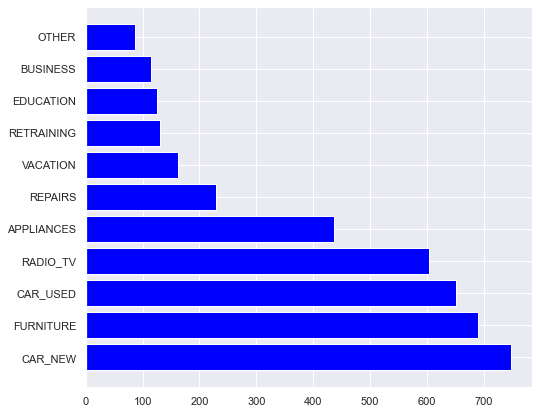

In [48]:
# Plota-se o gráfico entre os tipos de objetivo de empréstimo e quantidade de clientes
plt.rcParams["figure.figsize"] = (8,7)
plt.barh(montantes, result, color='blue')

### Montante do Empréstimo

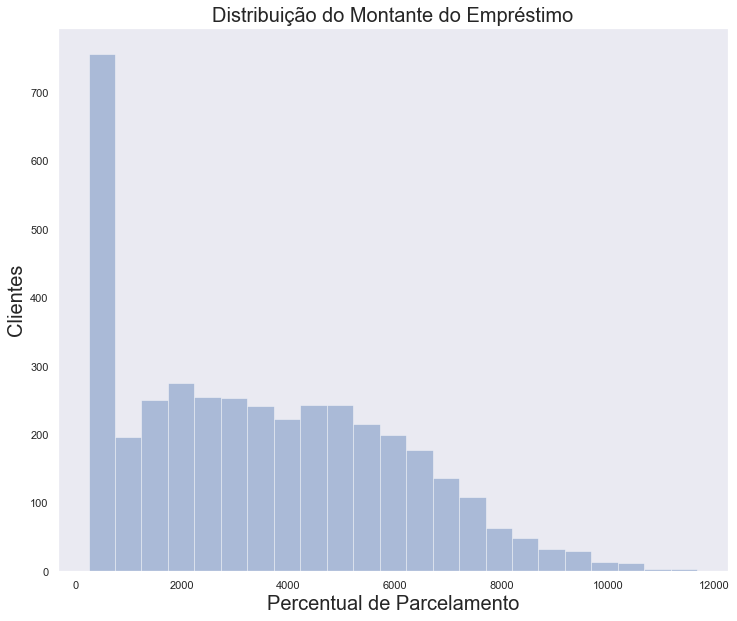

In [49]:
ax = sns.distplot(df3.LOAN_AMOUNT, kde = False)

ax.set_xlabel("Percentual de Parcelamento", 
              fontsize = 20, 
              position=(0.5,0))

ax.set_ylabel("Clientes", 
              fontsize = 20, 
              position=(0.5,0.5))

ax.grid(None)

ax.set_title('Distribuição do Montante do Empréstimo', 
             fontsize = 20)

ax.figure.set_size_inches(12,10)

### Outros Empréstimos Ativos

<BarContainer object of 3 artists>

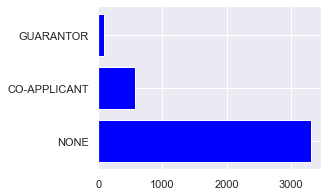

In [50]:
aux = df3['OTHERS_ON_LOAN'].value_counts()
result = []
for i in range(len(df3['OTHERS_ON_LOAN'].value_counts())):
    result.append(aux[i])

aux2 = pd.DataFrame(aux)
others = list(aux2.index)

plt.rcParams["figure.figsize"] = (4,3)
plt.barh(others, result, color='blue')

# Permitir Empréstimo?

Essa é variável no qual pretende-se classificar com a entrada de novos clientes. De forma objetiva, ela só pode retornar dois possíveis valores: 0 caso o modelo indique que o empréstimo não será concedido, e 1 caso o empréstimo será concedido.

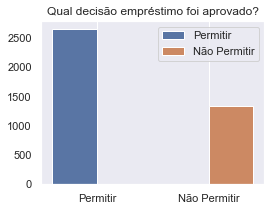

In [51]:
yes = len(df3[df3[u'ALLOW'] == 1])
no = len(df3[df3[u'ALLOW'] == 0])

new_df = {'Permitir': [yes], 'Não Permitir': [no]}

check_allow = pd.DataFrame(data=new_df)

sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_allow),
                  y=[check_allow['Permitir'].iloc[0],
                     check_allow['Não Permitir'].iloc[0]],
                     hue=list(check_allow))
plt.grid(None)
plt.title("Qual decisão empréstimo foi aprovado?")
plt.rcParams["figure.figsize"] = (6,8)
plt.show(fig)

# Visão Geral

Compreender cada variável é uma etapa importante no processo da resolução do problema, pois caso optemos por adicionar, tratar ou remover uma variável do modelo que será treinado e testado, é de suma importância entender o que essa variável representa e por qual razão foi tomada uma determinada decisão em relação a ela. Dessa maneira você receberá insights valiosos para a criação da sua narrativa para storytelling de dados.

Mas isso não é tudo, na próxima seção será construído o tratamento de dados ausentes, variáveis categóricas e uma análise exploratória juntando as bases de dados através do Pandas.

# Tratamento de Dados

O tratamento de dados pode ser construídos de 2 formas, a primeira trataria variáveis categóricas associadas a um id como 0 ou 1, seguindo a lógica de um "One Hot Encoder". Outra maneira, seria determinar índices associados a uma determinada variável categórica como, por exemplo: 0 - não informado, 1 - ruim, 2 - médio, 3 - bom.

## Tratamento de Dados 1 - Preparando a variável categórica 'histórico de crédito' para o modelo de classificação

## Juntando dataframes a partir do ID

In [93]:
df = pd.merge(pd.merge(df1,df2,on='ID'),df3,on='ID')
df

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT,SEX,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,...,PROPERTY,HOUSING,CURRENT_RESIDENCE_DURATION,PAYMENT_TERM,INSTALLMENT_PLANS,INSTALLMENT_PERCENT,LOAN_PURPOSE,LOAN_AMOUNT,OTHERS_ON_LOAN,ALLOW
0,291655,-566.53,ALL_CREDITS_PAID_BACK,36.42,1.0,F,24.0,3.0,1.0,1.0,...,SAVINGS_INSURANCE,OWN,2.0,310.0,NONE,2.0,CAR_NEW,3503.0,NONE,1
1,657079,-1673.16,CREDITS_PAID_TO_DATE,22.9,1.0,F,30.0,3.0,1.0,0.0,...,CAR_OTHER,RENT,1.0,630.0,STORES,3.0,CAR_NEW,3729.0,NONE,1
2,256050,NO_CHECKING,CREDITS_PAID_TO_DATE,450.35,2.0,M,40.0,3.0,1.0,0.0,...,UNKNOWN,OWN,4.0,868.0,NONE,3.0,CAR_USED,8516.0,NONE,0
3,1039151,-1471.03,PRIOR_PAYMENTS_DELAYED,805.71,2.0,M,28.0,1.0,1.0,0.0,...,CAR_OTHER,OWN,3.0,403.0,BANK,3.0,FURNITURE,2577.0,NONE,1
4,1002660,NO_CHECKING,CREDITS_PAID_TO_DATE,295.03,1.0,M,19.0,2.0,1.0,0.0,...,REAL_ESTATE,OWN,3.0,810.0,NONE,4.0,BUSINESS,3750.0,NONE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,636739,163.82,CREDITS_PAID_TO_DATE,472.11,1.0,F,41.0,0.0,1.0,0.0,...,CAR_OTHER,OWN,3.0,450.0,BANK,3.0,CAR_NEW,3007.0,CO-APPLICANT,0
2473,919733,14324.23,PRIOR_PAYMENTS_DELAYED,18652.44,1.0,M,46.0,3.0,1.0,1.0,...,SAVINGS_INSURANCE,OWN,3.0,510.0,NONE,4.0,VACATION,4191.0,GUARANTOR,1
2474,115839,130.13,PRIOR_PAYMENTS_DELAYED,726.78,2.0,M,28.0,3.0,1.0,1.0,...,CAR_OTHER,RENT,1.0,124.0,STORES,1.0,FURNITURE,250.0,NONE,1
2475,1128684,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0,M,46.0,0.0,1.0,0.0,...,CAR_OTHER,RENT,3.0,961.0,BANK,3.0,BUSINESS,5172.0,NONE,1


Observe que ao unir as bases de dados de clientes, uma nova análise pode ser construída, pois nessa nova etapa buscaremos compreender quais as correlações entre variáveis de diferentes bases se relacionam e claro, como essas variáveis influenciam a concessão de empréstimo a clientes ou não.

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          2477 non-null   int64  
 1   CHECKING_BALANCE            2467 non-null   object 
 2   CREDIT_HISTORY              2462 non-null   object 
 3   EXISTING_SAVINGS            2467 non-null   object 
 4   EXISTING_CREDITS_COUNT      2463 non-null   float64
 5   SEX                         2477 non-null   object 
 6   AGE                         2465 non-null   float64
 7   JOB_TYPE                    2464 non-null   float64
 8   DEPENDENTS                  2461 non-null   float64
 9   TELEPHONE                   2464 non-null   float64
 10  FOREIGN_WORKER              2463 non-null   float64
 11  EMPLOYMENT_DURATION         2472 non-null   float64
 12  PROPERTY                    2465 non-null   object 
 13  HOUSING                     2465 

In [95]:
df = df.fillna(method="ffill") # tratamento dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          2477 non-null   int64  
 1   CHECKING_BALANCE            2477 non-null   object 
 2   CREDIT_HISTORY              2477 non-null   object 
 3   EXISTING_SAVINGS            2477 non-null   object 
 4   EXISTING_CREDITS_COUNT      2477 non-null   float64
 5   SEX                         2477 non-null   object 
 6   AGE                         2477 non-null   float64
 7   JOB_TYPE                    2477 non-null   float64
 8   DEPENDENTS                  2477 non-null   float64
 9   TELEPHONE                   2477 non-null   float64
 10  FOREIGN_WORKER              2477 non-null   float64
 11  EMPLOYMENT_DURATION         2477 non-null   float64
 12  PROPERTY                    2477 non-null   object 
 13  HOUSING                     2477 

### Criamos uma função simples para retornar um dataframe com as correlações das variáveis de estudo

In [96]:
def update_corr(df):
    result_corr = df.corr().sort_values(by='ALLOW')
    result_corr = result_corr['ALLOW']

    return result_corr

In [97]:
update_corr(df) # testando função

AGE                          -0.452722
LOAN_AMOUNT                  -0.448757
PAYMENT_TERM                 -0.441380
EMPLOYMENT_DURATION          -0.436079
CURRENT_RESIDENCE_DURATION   -0.421804
INSTALLMENT_PERCENT          -0.405456
EXISTING_CREDITS_COUNT       -0.375336
TELEPHONE                    -0.333622
DEPENDENTS                   -0.216038
JOB_TYPE                     -0.092256
ID                           -0.027275
FOREIGN_WORKER                0.061020
ALLOW                         1.000000
Name: ALLOW, dtype: float64

### Observe que nove variáveis não apareceram na tabela de correlação mostrada anteriormente devido a necessidade de um tratamento de dados específico como, por exemplo, as variáveis categóricas.

In [98]:
enc = OneHotEncoder(cols=['CREDIT_HISTORY', 'SEX', 'PROPERTY','HOUSING','LOAN_PURPOSE','OTHERS_ON_LOAN','INSTALLMENT_PLANS'], use_cat_names=True)
enc.fit(df)

OneHotEncoder(cols=['CREDIT_HISTORY', 'SEX', 'PROPERTY', 'HOUSING',
                    'LOAN_PURPOSE', 'OTHERS_ON_LOAN', 'INSTALLMENT_PLANS'],
              use_cat_names=True)

In [99]:
df = enc.transform(df)
df

,ID,CHECKING_BALANCE,CREDIT_HISTORY_ALL_CREDITS_PAID_BACK,CREDIT_HISTORY_CREDITS_PAID_TO_DATE,CREDIT_HISTORY_PRIOR_PAYMENTS_DELAYED,CREDIT_HISTORY_OUTSTANDING_CREDIT,CREDIT_HISTORY_NO_CREDITS,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT,SEX_F,...,LOAN_PURPOSE_EDUCATION,LOAN_PURPOSE_VACATION,LOAN_PURPOSE_REPAIRS,LOAN_PURPOSE_RETRAINING,LOAN_PURPOSE_OTHER,LOAN_AMOUNT,OTHERS_ON_LOAN_NONE,OTHERS_ON_LOAN_CO-APPLICANT,OTHERS_ON_LOAN_GUARANTOR,ALLOW
0,291655,-566.53,1,0,0,0,0,36.42,1.0,1,...,0,0,0,0,0,3503.0,1,0,0,1
1,657079,-1673.16,0,1,0,0,0,22.9,1.0,1,...,0,0,0,0,0,3729.0,1,0,0,1
2,256050,NO_CHECKING,0,1,0,0,0,450.35,2.0,0,...,0,0,0,0,0,8516.0,1,0,0,0
3,1039151,-1471.03,0,0,1,0,0,805.71,2.0,0,...,0,0,0,0,0,2577.0,1,0,0,1
4,1002660,NO_CHECKING,0,1,0,0,0,295.03,1.0,0,...,0,0,0,0,0,3750.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,636739,163.82,0,1,0,0,0,472.11,1.0,1,...,0,0,0,0,0,3007.0,0,1,0,0
2473,919733,14324.23,0,0,1,0,0,18652.44,1.0,0,...,0,1,0,0,0,4191.0,0,0,1,1
2474,115839,130.13,0,0,1,0,0,726.78,2.0,0,...,0,0,0,0,0,250.0,1,0,0,1
2475,1128684,NO_CHECKING,0,0,1,0,0,UNKNOWN,1.0,0,...,0,0,0,0,0,5172.0,1,0,0,1


### Observe que as variáveis 'CHECKING_BALANCE ' e 'EXISTING_SAVINGS' ainda não foram tratadas, qual procedimento será realizado?

Com relação a variável 'CHECKING_BALANCE' uma das alternativas seria excluir todos os dados de contas que não tiveram seus balanços verificados, entretanto o conjunto de dados seria reduzido em aproximadamente 40% (de 2477 para 1485 dados), o que é um valor considerável tendo em vista que eliminar tantos dados reduziria a futura precisão do nosso modelo. 

In [100]:
af = df[~df['CHECKING_BALANCE'].isin(['NO_CHECKING'])] # excluindo todos os registros de contas com balanço não verificado
len(af) # tamanho do novo dataset, caso seja aprovado

1485

Uma alternativa seria transformar os dados numéricos em 4 tipos de informação:

- NEGATIVE: Compreende todas as contas com saldo negativo;
- ZERO: Compreende todas as contas zeradas;
- POSITIVE: Compreende todas as contas com saldo positivo;
- NO_CHECKING: Compreende todas as contas não verificadas (já existente).

Porém no momento, para fim de simplificação, opta-se por não utilizar a variável no modelo.

In [101]:
aux = df[~df['EXISTING_SAVINGS'].isin(['UNKNOWN'])]

In [102]:
aux = aux.drop(columns=['CHECKING_BALANCE'])

In [103]:
aux = aux.apply(pd.to_numeric)

In [104]:
update_corr(aux) # imprime a nova tabela de correlação com a inclusão da variável 'EXISTING_SAVINGS'

AGE                                     -0.443165
LOAN_AMOUNT                             -0.439912
PAYMENT_TERM                            -0.429587
EMPLOYMENT_DURATION                     -0.428706
CURRENT_RESIDENCE_DURATION              -0.417432
INSTALLMENT_PERCENT                     -0.398360
EXISTING_CREDITS_COUNT                  -0.355308
PROPERTY_UNKNOWN                        -0.347280
HOUSING_FREE                            -0.323946
TELEPHONE                               -0.319578
CREDIT_HISTORY_OUTSTANDING_CREDIT       -0.315826
OTHERS_ON_LOAN_CO-APPLICANT             -0.261064
DEPENDENTS                              -0.179579
INSTALLMENT_PLANS_NONE                  -0.176512
LOAN_PURPOSE_APPLIANCES                 -0.155806
EXISTING_SAVINGS                        -0.136933
OTHERS_ON_LOAN_GUARANTOR                -0.130609
CREDIT_HISTORY_PRIOR_PAYMENTS_DELAYED   -0.125372
LOAN_PURPOSE_REPAIRS                    -0.114325
PROPERTY_CAR_OTHER                      -0.113554


### Observação: Como a variável 'EXISTING_SAVINGS' possui uma correlação baixa com a nossa variável objetivo, então desfazemos o último tratamento que reduziu os dados em 7% (2400 para 2300 dados). Entretanto, mantém-se a decisão de excluir a variável 'CHECKING_BALANCE'.

In [105]:
df = df.drop(columns=['CHECKING_BALANCE'])

### Removendo todas colunas desnecessárias

In [106]:
df = df[['AGE','LOAN_AMOUNT','PAYMENT_TERM','EMPLOYMENT_DURATION','CURRENT_RESIDENCE_DURATION','INSTALLMENT_PERCENT','ALLOW']]
df

,AGE,LOAN_AMOUNT,PAYMENT_TERM,EMPLOYMENT_DURATION,CURRENT_RESIDENCE_DURATION,INSTALLMENT_PERCENT,ALLOW
0,24.0,3503.0,310.0,0.0,2.0,2.0,1
1,30.0,3729.0,630.0,5.0,1.0,3.0,1
2,40.0,8516.0,868.0,4.0,4.0,3.0,0
3,28.0,2577.0,403.0,0.0,3.0,3.0,1
4,19.0,3750.0,810.0,3.0,3.0,4.0,1
...,...,...,...,...,...,...,...
2472,41.0,3007.0,450.0,7.0,3.0,3.0,0
2473,46.0,4191.0,510.0,11.0,3.0,4.0,1
2474,28.0,250.0,124.0,7.0,1.0,1.0,1
2475,46.0,5172.0,961.0,7.0,3.0,3.0,1


### Análise de Outliers

Outra etapa importante da análise de dados é a de identificar possível valores extremos ou anomalias na nossa base de dados, pois esses valores podem comprometer o nosso modelo. 

#### Verificando a distribuição das variáveis do conjunto de dados

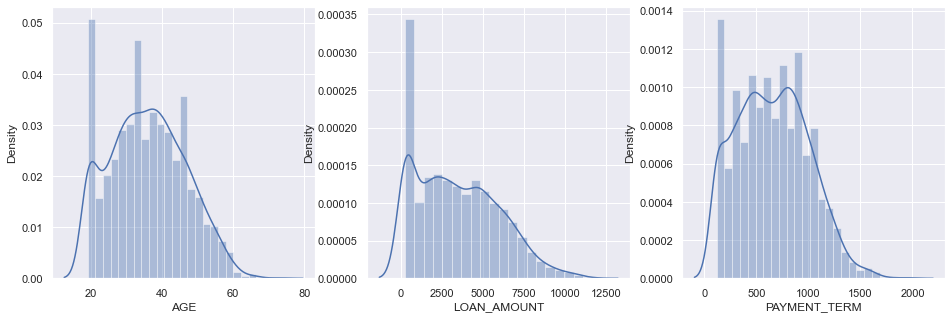

In [107]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.distplot(df['AGE'])
plt.subplot(1,3,2)
sns.distplot(df['LOAN_AMOUNT'])
plt.subplot(1,3,3)
sns.distplot(df['PAYMENT_TERM'])
plt.show()

<AxesSubplot:xlabel='INSTALLMENT_PERCENT', ylabel='Density'>

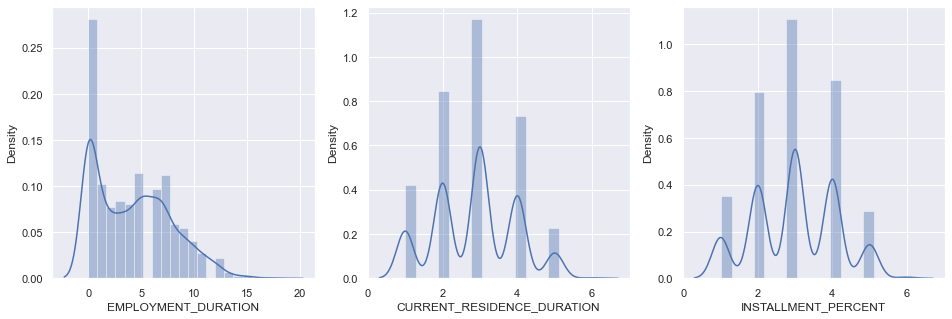

In [108]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.distplot(df['EMPLOYMENT_DURATION'])
plt.subplot(1,3,2)
sns.distplot(df['CURRENT_RESIDENCE_DURATION'])
plt.subplot(1,3,3)
sns.distplot(df['INSTALLMENT_PERCENT'])

Observando os gráficos de distribuição por variável é possível notar que elas não seguem a distribuição normal. Dessa forma a técnica que será utilizada para detectar outliers não poderá ser baseada na Z-Score. Como alternativa utiliza-se uma técnica baseada no IQR ou, em outras palavras, a amplitude interquartil.

### Boxplot das variáveis

<AxesSubplot:xlabel='PAYMENT_TERM'>

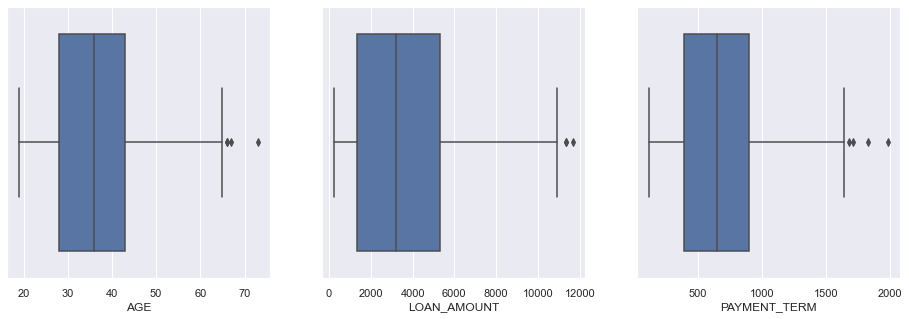

In [138]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.boxplot(df['AGE'])
plt.subplot(1,3,2)
sns.boxplot(df['LOAN_AMOUNT'])
plt.subplot(1,3,3)
sns.boxplot(df['PAYMENT_TERM'])

<AxesSubplot:xlabel='INSTALLMENT_PERCENT'>

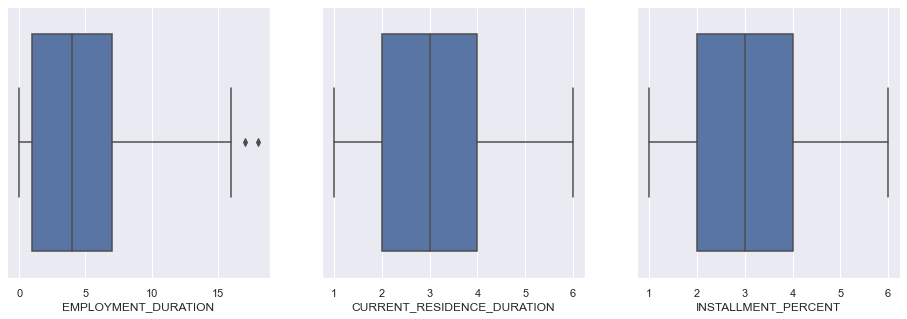

In [141]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.boxplot(df['EMPLOYMENT_DURATION'])
plt.subplot(1,3,2)
sns.boxplot(df['CURRENT_RESIDENCE_DURATION'])
plt.subplot(1,3,3)
sns.boxplot(df['INSTALLMENT_PERCENT'])

Observe que nem todas as variáveis tem indícios de presença de outliers. Nesse caso, aplicaremos a técnica de remoção de outliers apenas nas variáveis 'AGE', 'LOAN_AMOUNT', 'PAYMENT_TERM' e 'EMPLOYMENT_DURATION'. 

Obs.: Para avaliar melhor o impacto que a remoção de outliers proporciona, será realizado análise individual por variável.

In [144]:
# aplica IQR a variável 'AGE'
percentil25 = df['AGE'].quantile(0.25)
percentil75 = df['AGE'].quantile(0.75)
        
upper_limit = percentil75 + 1.5 * (percentil75-percentil25)
lower_limit = percentil25 - 1.5 * (percentil75-percentil25)

df[df['AGE'] > upper_limit]
df[df['AGE'] < lower_limit]

df = df[df['AGE'] < upper_limit]
df

,AGE,LOAN_AMOUNT,PAYMENT_TERM,EMPLOYMENT_DURATION,CURRENT_RESIDENCE_DURATION,INSTALLMENT_PERCENT,ALLOW
0,24.0,3503.0,310.0,0.0,2.0,2.0,1
1,30.0,3729.0,630.0,5.0,1.0,3.0,1
2,40.0,8516.0,868.0,4.0,4.0,3.0,0
3,28.0,2577.0,403.0,0.0,3.0,3.0,1
4,19.0,3750.0,810.0,3.0,3.0,4.0,1
...,...,...,...,...,...,...,...
2472,41.0,3007.0,450.0,7.0,3.0,3.0,0
2473,46.0,4191.0,510.0,11.0,3.0,4.0,1
2474,28.0,250.0,124.0,7.0,1.0,1.0,1
2475,46.0,5172.0,961.0,7.0,3.0,3.0,1


In [146]:
# aplica IQR a variável 'LOAN_AMOUNT'

percentil25 = df['LOAN_AMOUNT'].quantile(0.25)
percentil75 = df['LOAN_AMOUNT'].quantile(0.75)
        
upper_limit = percentil75 + 1.5 * (percentil75-percentil25)
lower_limit = percentil25 - 1.5 * (percentil75-percentil25)

df[df['LOAN_AMOUNT'] > upper_limit]
df[df['LOAN_AMOUNT'] < lower_limit]

df = df[df['LOAN_AMOUNT'] < upper_limit]
df

,AGE,LOAN_AMOUNT,PAYMENT_TERM,EMPLOYMENT_DURATION,CURRENT_RESIDENCE_DURATION,INSTALLMENT_PERCENT,ALLOW
0,24.0,3503.0,310.0,0.0,2.0,2.0,1
1,30.0,3729.0,630.0,5.0,1.0,3.0,1
2,40.0,8516.0,868.0,4.0,4.0,3.0,0
3,28.0,2577.0,403.0,0.0,3.0,3.0,1
4,19.0,3750.0,810.0,3.0,3.0,4.0,1
...,...,...,...,...,...,...,...
2472,41.0,3007.0,450.0,7.0,3.0,3.0,0
2473,46.0,4191.0,510.0,11.0,3.0,4.0,1
2474,28.0,250.0,124.0,7.0,1.0,1.0,1
2475,46.0,5172.0,961.0,7.0,3.0,3.0,1


In [147]:
# aplica IQR a variável 'PAYMENT_TERM'

percentil25 = df['PAYMENT_TERM'].quantile(0.25)
percentil75 = df['PAYMENT_TERM'].quantile(0.75)
        
upper_limit = percentil75 + 1.5 * (percentil75-percentil25)
lower_limit = percentil25 - 1.5 * (percentil75-percentil25)

df[df['PAYMENT_TERM'] > upper_limit]
df[df['PAYMENT_TERM'] < lower_limit]

df = df[df['PAYMENT_TERM'] < upper_limit]
df

,AGE,LOAN_AMOUNT,PAYMENT_TERM,EMPLOYMENT_DURATION,CURRENT_RESIDENCE_DURATION,INSTALLMENT_PERCENT,ALLOW
0,24.0,3503.0,310.0,0.0,2.0,2.0,1
1,30.0,3729.0,630.0,5.0,1.0,3.0,1
2,40.0,8516.0,868.0,4.0,4.0,3.0,0
3,28.0,2577.0,403.0,0.0,3.0,3.0,1
4,19.0,3750.0,810.0,3.0,3.0,4.0,1
...,...,...,...,...,...,...,...
2472,41.0,3007.0,450.0,7.0,3.0,3.0,0
2473,46.0,4191.0,510.0,11.0,3.0,4.0,1
2474,28.0,250.0,124.0,7.0,1.0,1.0,1
2475,46.0,5172.0,961.0,7.0,3.0,3.0,1


In [148]:
# aplica IQR a variável 'EMPLOYMENT_DURATION'

percentil25 = df['PAYMENT_TERM'].quantile(0.25)
percentil75 = df['PAYMENT_TERM'].quantile(0.75)
        
upper_limit = percentil75 + 1.5 * (percentil75-percentil25)
lower_limit = percentil25 - 1.5 * (percentil75-percentil25)

df[df['PAYMENT_TERM'] > upper_limit]
df[df['PAYMENT_TERM'] < lower_limit]

df = df[df['PAYMENT_TERM'] < upper_limit]
df

,AGE,LOAN_AMOUNT,PAYMENT_TERM,EMPLOYMENT_DURATION,CURRENT_RESIDENCE_DURATION,INSTALLMENT_PERCENT,ALLOW
0,24.0,3503.0,310.0,0.0,2.0,2.0,1
1,30.0,3729.0,630.0,5.0,1.0,3.0,1
2,40.0,8516.0,868.0,4.0,4.0,3.0,0
3,28.0,2577.0,403.0,0.0,3.0,3.0,1
4,19.0,3750.0,810.0,3.0,3.0,4.0,1
...,...,...,...,...,...,...,...
2472,41.0,3007.0,450.0,7.0,3.0,3.0,0
2473,46.0,4191.0,510.0,11.0,3.0,4.0,1
2474,28.0,250.0,124.0,7.0,1.0,1.0,1
2475,46.0,5172.0,961.0,7.0,3.0,3.0,1


##### Removemos um total de 11 outliers, esse valor pode parecer baixo, entretanto, em casos de grandes volumes de dados não tratar esses dados pode dificultar o modo como os seus futuros modelos de aprendizado de máquina aprenderão.

# Fase 2: Treino, Teste e Aplicação do Algoritmo de Random Forest

In [290]:
train, test = train_test_split(df, train_size=0.80) # dividimos o dataset em treino (70%) e teste (30%)

In [291]:
X_train = train.drop('ALLOW', axis=1)
X_val = test.drop('ALLOW', axis=1)

y_train = train['ALLOW']
y_val = test['ALLOW']

In [292]:
mdl = RandomForestRegressor(n_jobs=8, n_estimators=100, random_state=22)
mdl.fit(X_train, y_train)

RandomForestRegressor(n_jobs=8, random_state=22)

In [293]:
p_ohe = mdl.predict(X_val)

In [294]:
mean_absolute_error(y_val, p_ohe)

0.3111241565452092

In [295]:
from sklearn.metrics import r2_score

In [296]:
r2_score(y_val, p_ohe)

0.26512435721748784

# Fase 3: Criando função para deploy do modelo

In [ ]:
def credito(dados):
    pass